In [1]:
# Standard Libraries
import argparse
import os
import sys
from tqdm import tqdm

# Python Modules
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple
import gc

# Type Hint Libraries
from typing import Optional, Tuple, Union, TypeVar, List
import numpy.typing as npt
import matplotlib.figure
from torch import Tensor

# Math and Data Science Libraries
import numpy as np
import pandas as pd
from scipy.ndimage.filters import convolve

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader


# Image Libraries
import cv2

import skimage as ski
from skimage import io
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

# User defined methods and classes
sys.path.insert(0,'/content/drive/MyDrive/')

<ipython-input-1-40cc5f65a5b0>:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
from utils import parse_line
from utils import lines_to_polygons
from utils import build_mask_dataset
from utils import mask_in_set
from utils import nodes_to_points
from utils import plot_image_and_mask
from utils import create_binary_mask

from Unet_model import UNET

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Path to dataset
DATA_PATH = '/content/drive/MyDrive/PNG/'
# Creating a path to save masks
MASKS_PATH = '/content/drive/MyDrive/masks/'
# Creating a path to save model
MODEL_PATH = '/content/drive/MyDrive/model/unet_weigths_v9.pth'

In [5]:
# Creates a list of the *.png file names in the dataset
image_files = os.listdir(DATA_PATH)

In [6]:
image_names = []

for file_name in image_files:
    image_names.append(file_name.replace('.png',''))

In [7]:
print(len(image_names))
image_names = image_names[:1701]

1705


In [8]:
train_image_names, test_image_names, _, _ = train_test_split(image_names, image_names, test_size=0.2, random_state=42)

In [9]:
train_images = []
test_images = []
train_masks = []
test_masks = []

In [10]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    train_images.append(rgb2gray(curr_image))

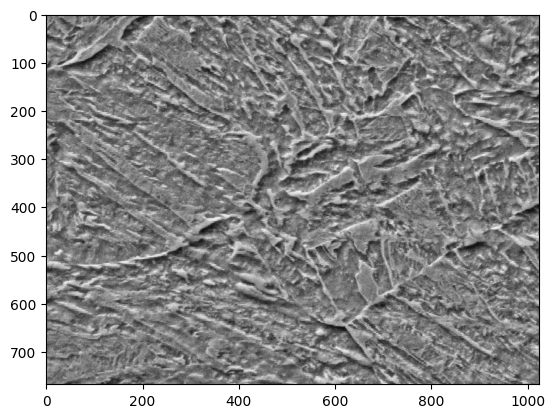

In [11]:
# Testing images were loaded correctly
plt.imshow(train_images[0], cmap=plt.cm.gray)
plt.show()

In [12]:
print('Image shape:         ',train_images[0].shape)
print('Element type:        ',train_images[0].dtype)
print('Data structure type: ',type(train_images[0]))
print('Max. value:          ',np.max(train_images[0]))
print('Min. value:          ',np.min(train_images[0]))
print('Length images:       ',len(train_images))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           0.9294117647058825
Min. value:           0.06274509803921569
Length images:        1360


In [13]:
# Loading train masks as grayscale images
for name in train_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    train_masks.append(rgb2gray(curr_mask).round())

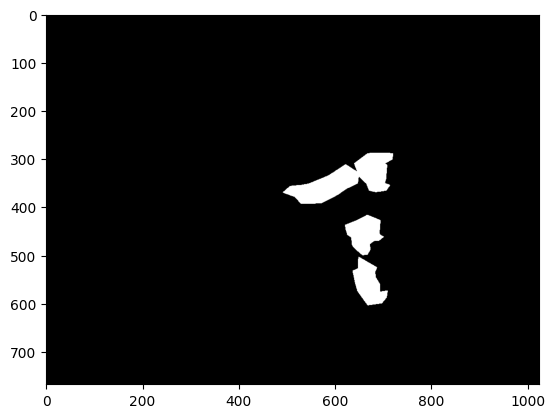

In [14]:
# Testing images were loaded correctly
plt.imshow(train_masks[0], cmap=plt.cm.gray)
plt.show()

In [15]:
print('Image shape:         ',train_masks[0].shape)
print('Element type:        ',train_masks[0].dtype)
print('Data structure type: ',type(train_masks[0]))
print('Max. value:          ',np.max(train_masks[0]))
print('Min. value:          ',np.min(train_masks[0]))
print('Length masks:        ',len(train_masks))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           1.0
Min. value:           0.0
Length masks:         1360


In [16]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    test_images.append(rgb2gray(curr_image))

In [17]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    test_masks.append(rgb2gray(curr_mask).round())

First I created a custom Dataset class for this particular dataset:

In [18]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, images: list, masks: list):
        super(DataLoaderSegmentation, self).__init__()
        assert len(images) == len(masks), 'Length of image list must be the same of masks list'
        self.img = np.array(images)
        self.msk = np.array(masks)

    def __getitem__(self, index)->Tuple[Tensor]:
            data = self.img[index]
            label = self.msk[index]
            return torch.unsqueeze(torch.from_numpy(data).float(),0), torch.unsqueeze(torch.from_numpy(label).float(),0)

    def __len__(self):
        return len(self.img)

In [19]:
train_dataset = DataLoaderSegmentation(train_images,train_masks)
test_dataset = DataLoaderSegmentation(test_images,test_masks)

Next step is creating a dataloader for the network

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Model

In [21]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4                                          # Paper uses lr=2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # Paper uses 20
NUM_EPOCHS = 3                                                # Paper uses 1e10 if
NUM_WORKERS = 2                                               # paper uses 0
IMAGE_HEIGHT = 768
IMAGE_WIDTH = 1024
PIN_MEMORY = True
LOAD_MODEL = False
loss_fn = torch.nn.BCEWithLogitsLoss()                        # Paper uses losses.DiceBCELoss(weight=0.7)
scaler = torch.cuda.amp.GradScaler()
model = UNET().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Paper uses Adam
# metrics = [smp.utils.metrics.IoU(threshold=0.5),]           # Coming from the paper

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    loop = tqdm(dataloader)

    loss_20_batches = 0
    loss_epoch = 0

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (image, mask) in enumerate(loop):

        image = image.to(DEVICE)
        mask = mask.to(DEVICE)

        with torch.cuda.amp.autocast(): # Mod
            # Compute prediction and loss
            pred = model(image)
            loss = loss_fn(pred, mask)
            loss_20_batches += loss
            loss_epoch += loss

        # Backpropagation Mod
        optimizer.zero_grad()         # Original 1: loss.backward()
        scaler.scale(loss.to(DEVICE)).backward() # Original 2: optimizer.step()
        scaler.step(optimizer)        # Original 3: optimizer.zero_grad()
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        if batch % 20 == 0:
            loop.set_postfix(loss_20_batches=loss_20_batches.item()/20)
            loss_20_batches = 0

    print(f"==> training_loss: {loss_epoch/len(dataloader):2f}")

In [23]:
def test_loop(dataloader, model, loss_fn):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    loss_epoch = 0

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for batch, (image, mask) in enumerate(dataloader):

            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            pred = model(image)

            loss_epoch += loss_fn(pred, mask)
            mask_pred = torch.sigmoid(pred)
            mask_pred = (mask_pred > 0.5).float()

            num_correct += (mask_pred == mask).sum()
            num_pixels += torch.numel(mask_pred)
            dice_score += (2 * (mask_pred * mask).sum()) / (
                    (mask_pred + mask).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {(num_correct/num_pixels)*100:.2f}"
    )
    print(
        f"==> valuation_loss: {loss_epoch/len(dataloader):2f}"
    )

    print(f"==> dice_score: {dice_score/len(dataloader)}")

    model.train()

In [24]:
DEVICE

'cuda'

In [25]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 85/85 [01:44<00:00,  1.23s/it, loss=0.393]


==> training_loss: 0.483960
Got 245581414/268173312 with acc 91.58
==> valuation_loss: 0.437974
==> dice_score: 0.2759244441986084
Epoch 2
-------------------------------


100%|██████████| 85/85 [02:15<00:00,  1.59s/it, loss=0.364]


==> training_loss: 0.368290
Got 241635782/268173312 with acc 90.10
==> valuation_loss: 0.374147
==> dice_score: 0.4436648190021515
Epoch 3
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.306]


==> training_loss: 0.322884
Got 250231261/268173312 with acc 93.31
==> valuation_loss: 0.296993
==> dice_score: 0.40696048736572266
Epoch 4
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.268]


==> training_loss: 0.289517
Got 250779246/268173312 with acc 93.51
==> valuation_loss: 0.277040
==> dice_score: 0.5091829895973206
Epoch 5
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.253]


==> training_loss: 0.263804
Got 250722078/268173312 with acc 93.49
==> valuation_loss: 0.263741
==> dice_score: 0.4051286578178406
Epoch 6
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.216]


==> training_loss: 0.242070
Got 251632283/268173312 with acc 93.83
==> valuation_loss: 0.235469
==> dice_score: 0.5388994216918945
Epoch 7
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.229]


==> training_loss: 0.222926
Got 249975246/268173312 with acc 93.21
==> valuation_loss: 0.229002
==> dice_score: 0.4855468273162842
Epoch 8
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.222]


==> training_loss: 0.208134
Got 252398579/268173312 with acc 94.12
==> valuation_loss: 0.204809
==> dice_score: 0.48255252838134766
Epoch 9
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.173]


==> training_loss: 0.196354
Got 252939900/268173312 with acc 94.32
==> valuation_loss: 0.202034
==> dice_score: 0.5561174750328064
Epoch 10
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.18]


==> training_loss: 0.184435
Got 252803029/268173312 with acc 94.27
==> valuation_loss: 0.188958
==> dice_score: 0.570587158203125
Epoch 11
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.158]


==> training_loss: 0.176370
Got 250522861/268173312 with acc 93.42
==> valuation_loss: 0.195431
==> dice_score: 0.5915653109550476
Epoch 12
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.161]


==> training_loss: 0.168940
Got 253187409/268173312 with acc 94.41
==> valuation_loss: 0.168565
==> dice_score: 0.5459631085395813
Epoch 13
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.176]


==> training_loss: 0.161379
Got 252940169/268173312 with acc 94.32
==> valuation_loss: 0.167039
==> dice_score: 0.5568811297416687
Epoch 14
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.184]


==> training_loss: 0.156208
Got 253239268/268173312 with acc 94.43
==> valuation_loss: 0.158280
==> dice_score: 0.5755953788757324
Epoch 15
-------------------------------


100%|██████████| 85/85 [02:14<00:00,  1.58s/it, loss=0.147]


==> training_loss: 0.150519
Got 251823394/268173312 with acc 93.90
==> valuation_loss: 0.168129
==> dice_score: 0.5760324001312256
Done!


In [26]:
torch.save(model.state_dict(), MODEL_PATH)

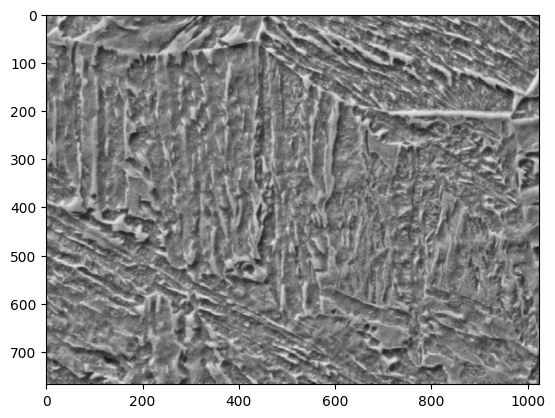

In [27]:
# Testing images were loaded correctly
plt.imshow(train_images[11], cmap=plt.cm.gray)
plt.show()

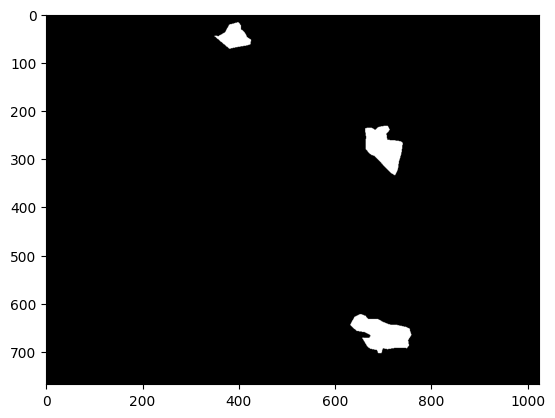

In [28]:
# Testing images were loaded correctly
plt.imshow(train_masks[11], cmap=plt.cm.gray)
plt.show()

In [29]:
test_im = train_masks[11]
test_im = torch.tensor(test_im).unsqueeze(dim=0).unsqueeze(dim=0).float()
test_im.shape

torch.Size([1, 1, 768, 1024])

In [30]:
pred = model(test_im.to(DEVICE))

In [31]:
pred.shape

torch.Size([1, 1, 768, 1024])

In [32]:
mask_pred = torch.sigmoid(pred)
mask_pred = (mask_pred > 0.5).float()

In [33]:
a = Tensor.cpu(pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
a

array([[-1.4906081, -2.0590591, -2.1664448, ..., -2.0826368, -2.0754406,
        -1.6608462],
       [-1.887601 , -2.6227052, -2.9316783, ..., -2.634489 , -2.6214998,
        -2.1158514],
       [-2.0188446, -2.8669682, -3.022235 , ..., -2.7639081, -2.6475155,
        -2.2085254],
       ...,
       [-1.9658267, -2.6670418, -2.867044 , ..., -2.7103305, -2.5860949,
        -2.0813625],
       [-1.817573 , -2.544938 , -2.7198355, ..., -2.5715172, -2.5352027,
        -2.1785793],
       [-1.443271 , -1.8313324, -2.0013306, ..., -1.849526 , -1.8602434,
        -1.7564746]], dtype=float32)

In [34]:
b = Tensor.cpu(mask_pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

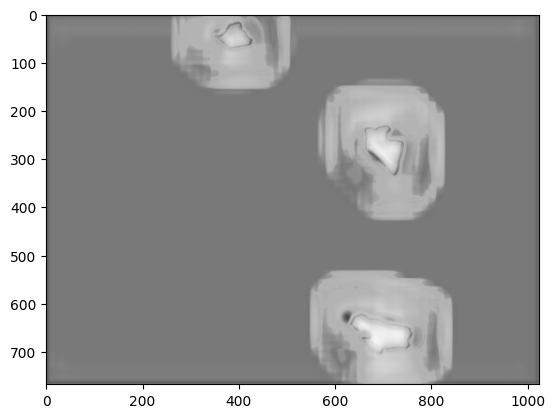

In [35]:
# Visualizing predicted mask
plt.imshow(a, cmap=plt.cm.gray)
plt.show()

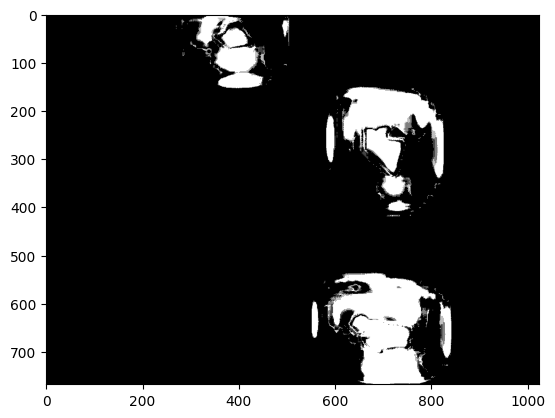

In [36]:
# Visualizing predicted mask
plt.imshow(b, cmap=plt.cm.gray)
plt.show()